In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import load_model, Model
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib
import requests
import base64
import os
from pathlib import Path
from io import BytesIO

matplotlib.rcParams["figure.figsize"] = (12, 12)
matplotlib.rcParams["axes.grid"] = False

# Utility Functions

In [3]:
def load_image(image_path, dim=None, resize=False):
    img = Image.open(image_path)
    if dim:
        if resize:
            img = img.resize(dim)
        else:
            img.thumbnail(dim)
    img = img.convert("RGB")
    return np.array(img)

In [4]:
def load_url_image(url, dim=None, resize=False):
    img_request = requests.get(url)
    img = Image.open(BytesIO(img_request.content))
    if dim:
        if resize:
            img = img.resize(dim)
        else:
            img.thumbnail(dim)
    img = img.convert("RGB")
    return np.array(img)

In [5]:
def array_to_img(array):
    array = np.array(array, dtype=np.uint8)
    if np.ndim(array) > 3:
        assert array.shape[0] == 1
        array = array[0]
    return Image.fromarray(array)

In [6]:
def show_image(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title = title

In [7]:
def plot_images_grid(images, num_rows=1):
    n = len(images)
    if n > 1:
        num_cols = np.ceil(n / num_rows)
        fig, axes = plt.subplots(ncols=int(num_cols), nrows=int(num_rows))
        axes = axes.flatten()
        fig.set_size_inches((15, 15))
        for i, image in enumerate(images):
            axes[i].imshow(image)
    else:
        plt.figure(figsize=(10, 10))
        plt.imshow(images[0])

# Pretrained Model Instantiate

In [8]:
vgg = vgg19.VGG19(weights="imagenet", include_top=False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Defining Content and Style layers from pretrained model

In [9]:
content_layers = ["block4_conv2"]
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layers_weights = [1]
style_layers_weights = [1] * 5

# Creating Loss model it is used to calcuate perceptual loss

In [10]:
class LossModel:
    def __init__(self, pretrained_model, content_layers, style_layers):
        self.model = pretrained_model
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.loss_model = self.get_model()

    def get_model(self):
        self.model.trainable = False
        layer_names = self.style_layers + self.content_layers
        outputs = [self.model.get_layer(name).output for name in layer_names]
        new_model = Model(inputs=self.model.input, outputs=outputs)
        return new_model

    def get_activations(self, inputs):
        inputs = inputs * 255.0
        style_length = len(self.style_layers)
        outputs = self.loss_model(vgg19.preprocess_input(inputs))
        style_output, content_output = outputs[:style_length], outputs[style_length:]
        content_dict = {
            name: value for name, value in zip(self.content_layers, content_output)
        }
        style_dict = {
            name: value for name, value in zip(self.style_layers, style_output)
        }
        return {"content": content_dict, "style": style_dict}

In [11]:
loss_model = LossModel(vgg, content_layers, style_layers)

# Defining Losses

In [12]:
def content_loss(placeholder, content, weight):
    assert placeholder.shape == content.shape
    return weight * tf.reduce_mean(tf.square(placeholder - content))

In [13]:
def gram_matrix(x):
    gram = tf.linalg.einsum("bijc,bijd->bcd", x, x)
    return gram / tf.cast(x.shape[1] * x.shape[2] * x.shape[3], tf.float32)

In [14]:
def style_loss(placeholder, style, weight):
    assert placeholder.shape == style.shape
    s = gram_matrix(style)
    p = gram_matrix(placeholder)
    return weight * tf.reduce_mean(tf.square(s - p))

In [15]:
def preceptual_loss(
    predicted_activations,
    content_activations,
    style_activations,
    content_weight,
    style_weight,
    content_layers_weights,
    style_layer_weights,
):
    pred_content = predicted_activations["content"]
    pred_style = predicted_activations["style"]
    c_loss = tf.add_n(
        [
            content_loss(
                pred_content[name], content_activations[name], content_layers_weights[i]
            )
            for i, name in enumerate(pred_content.keys())
        ]
    )
    c_loss = c_loss * content_weight
    s_loss = tf.add_n(
        [
            style_loss(
                pred_style[name], style_activations[name], style_layer_weights[i]
            )
            for i, name in enumerate(pred_style.keys())
        ]
    )
    s_loss = s_loss * style_weight
    return c_loss + s_loss

# Fast Neural Style Transfer Model Architecture
- Residual Layers
- Encoder Decoder Model

In [16]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super(ReflectionPadding2D, self).__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor):
        padding_width, padding_height = self.padding
        return tf.pad(
            input_tensor,
            [
                [0, 0],
                [padding_height, padding_height],
                [padding_width, padding_width],
                [0, 0],
            ],
            "REFLECT",
        )

In [17]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        batch, rows, cols, channels = [i for i in inputs.get_shape()]
        mu, var = tf.nn.moments(inputs, [1, 2], keepdims=True)
        shift = tf.Variable(tf.zeros([channels]))
        scale = tf.Variable(tf.ones([channels]))
        epsilon = 1e-3
        normalized = (inputs - mu) / tf.sqrt(var + epsilon)
        return scale * normalized + shift

In [18]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        self.padding = ReflectionPadding2D([k // 2 for k in kernel_size])
        self.conv2d = tf.keras.layers.Conv2D(filters, kernel_size, strides)
        self.bn = InstanceNormalization()

    def call(self, inputs):
        x = self.padding(inputs)
        x = self.conv2d(x)
        x = self.bn(x)
        return x

In [19]:
class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(ResidualLayer, self).__init__(**kwargs)
        self.conv2d_1 = ConvLayer(filters, kernel_size)
        self.conv2d_2 = ConvLayer(filters, kernel_size)
        self.relu = tf.keras.layers.ReLU()
        self.add = tf.keras.layers.Add()

    def call(self, inputs):
        residual = inputs
        x = self.conv2d_1(inputs)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.add([x, residual])
        return x

In [20]:
class UpsampleLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, upsample=2, **kwargs):
        super(UpsampleLayer, self).__init__(**kwargs)
        self.upsample = tf.keras.layers.UpSampling2D(size=upsample)
        self.padding = ReflectionPadding2D([k // 2 for k in kernel_size])
        self.conv2d = tf.keras.layers.Conv2D(filters, kernel_size, strides)
        self.bn = InstanceNormalization()

    def call(self, inputs):
        x = self.upsample(inputs)
        x = self.padding(x)
        x = self.conv2d(x)
        return self.bn(x)

In [21]:
class StyleTransferModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(StyleTransferModel, self).__init__(name="StyleTransferModel", **kwargs)
        self.conv2d_1 = ConvLayer(
            filters=32, kernel_size=(9, 9), strides=1, name="conv2d_1_32"
        )
        self.conv2d_2 = ConvLayer(
            filters=64, kernel_size=(3, 3), strides=2, name="conv2d_2_64"
        )
        self.conv2d_3 = ConvLayer(
            filters=128, kernel_size=(3, 3), strides=2, name="conv2d_3_128"
        )
        self.res_1 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_1_128")
        self.res_2 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_2_128")
        self.res_3 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_3_128")
        self.res_4 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_4_128")
        self.res_5 = ResidualLayer(filters=128, kernel_size=(3, 3), name="res_5_128")
        self.deconv2d_1 = UpsampleLayer(
            filters=64, kernel_size=(3, 3), name="deconv2d_1_64"
        )
        self.deconv2d_2 = UpsampleLayer(
            filters=32, kernel_size=(3, 3), name="deconv2d_2_32"
        )
        self.deconv2d_3 = ConvLayer(
            filters=3, kernel_size=(9, 9), strides=1, name="deconv2d_3_3"
        )
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.relu(x)
        x = self.conv2d_2(x)
        x = self.relu(x)
        x = self.conv2d_3(x)
        x = self.relu(x)
        x = self.res_1(x)
        x = self.res_2(x)
        x = self.res_3(x)
        x = self.res_4(x)
        x = self.res_5(x)
        x = self.deconv2d_1(x)
        x = self.relu(x)
        x = self.deconv2d_2(x)
        x = self.relu(x)
        x = self.deconv2d_3(x)
        x = (tf.nn.tanh(x) + 1) * (255.0 / 2)
        return x

    def print_shape(self, inputs):
        print(inputs.shape)
        x = self.conv2d_1(inputs)
        print(x.shape)
        x = self.relu(x)
        x = self.conv2d_2(x)
        print(x.shape)
        x = self.relu(x)
        x = self.conv2d_3(x)
        print(x.shape)
        x = self.relu(x)
        x = self.res_1(x)
        print(x.shape)
        x = self.res_2(x)
        print(x.shape)
        x = self.res_3(x)
        print(x.shape)
        x = self.res_4(x)
        print(x.shape)
        x = self.res_5(x)
        print(x.shape)
        x = self.deconv2d_1(x)
        print(x.shape)
        x = self.relu(x)
        x = self.deconv2d_2(x)
        print(x.shape)
        x = self.relu(x)
        x = self.deconv2d_3(x)
        print(x.shape)

In [22]:
input_shape = (256, 256, 3)
batch_size = 4

In [23]:
style_model = StyleTransferModel()

In [24]:
style_model.print_shape(tf.zeros(shape=(1, *input_shape)))

(1, 256, 256, 3)
(1, 256, 256, 32)
(1, 128, 128, 64)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 64, 64, 128)
(1, 128, 128, 64)
(1, 256, 256, 32)
(1, 256, 256, 3)


# Training Utility Functions

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [26]:
def train_step(
    dataset,
    style_activations,
    steps_per_epoch,
    style_model,
    loss_model,
    optimizer,
    checkpoint_path="./",
    content_weight=1e4,
    style_weight=1e-2,
    total_variation_weight=0.004,
    content_layers_weights=[1],
    style_layers_weights=[1] * 5,
):
    batch_losses = []
    steps = 1
    save_path = os.path.join(checkpoint_path, f"model_checkpoint.ckpt")
    print("Model Checkpoint Path: ", save_path)
    for input_image_batch in dataset:
        if steps - 1 >= steps_per_epoch:
            break
        with tf.GradientTape() as tape:
            outputs = style_model(input_image_batch)
            outputs = tf.clip_by_value(outputs, 0, 255)
            pred_activations = loss_model.get_activations(outputs / 255.0)
            content_activations = loss_model.get_activations(input_image_batch)[
                "content"
            ]
            curr_loss = preceptual_loss(
                pred_activations,
                content_activations,
                style_activations,
                content_weight,
                style_weight,
                content_layers_weights,
                style_layers_weights,
            )
            curr_loss += total_variation_weight * tf.image.total_variation(outputs)
        batch_losses.append(curr_loss)
        grad = tape.gradient(curr_loss, style_model.trainable_variables)
        optimizer.apply_gradients(zip(grad, style_model.trainable_variables))
        if steps % 1000 == 0:
            print("checkpoint saved ", end=" ")
            style_model.save_weights(save_path)
            print(f"Loss: {tf.reduce_mean(batch_losses).numpy()}")
        steps += 1
    return tf.reduce_mean(batch_losses)

# Configure Dataset for training

In [27]:
# Downloading or scraping some images from internet (nature,person,portrait,dogs,cat,moutains,paintings,city,traffic,horses,monkey,indoor scenes ..etc )
from google.colab import drive

drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [27]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2024-03-22 01:40:34--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.66.33, 3.5.25.97, 52.217.163.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.66.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  41.9MB/s    in 3m 57s  

2024-03-22 01:44:31 (54.3 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [28]:
!mkdir coco
!unzip -qq train2014.zip -d coco

mkdir: cannot create directory ‘coco’: File exists
replace coco/train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000101772.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000359320.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000486482.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000116155.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000082143.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000242307.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000510484.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coco/train2014/COCO_train2014_000000339597.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace coco/train2014/COCO_train2014_000000339597.

In [29]:
!rm train2014.zip

In [28]:
class TensorflowDatasetLoader:
    def __init__(
        self, dataset_path, batch_size=4, image_size=(256, 256), num_images=None
    ):
        images_paths = [str(path) for path in Path(dataset_path).glob("*.jpg")]
        self.length = len(images_paths)
        if num_images is not None:
            images_paths = images_paths[0:num_images]
        dataset = tf.data.Dataset.from_tensor_slices(images_paths).map(
            lambda path: self.load_tf_image(path, dim=image_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.repeat()
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        self.dataset = dataset

    def __len__(self):
        return self.length

    def load_tf_image(self, image_path, dim):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, dim)
        image = image / 255.0
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image

In [60]:
import os
import random
import shutil

# Define paths
source_folder = 'coco/train2014/'
destination_folder = 'coco/traindata'
num_images_to_select = 100

# List all files in the source folder
all_images = os.listdir(source_folder)

# Randomly select 100 images
selected_images = random.sample(all_images, num_images_to_select)

# Create destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Move selected images to the destination folder
for image in selected_images:
    source_path = os.path.join(source_folder, image)
    destination_path = os.path.join(destination_folder, image)
    shutil.move(source_path, destination_path)

print("Selected images moved to the destination folder.")


Selected images moved to the destination folder.


In [61]:
loader = TensorflowDatasetLoader("coco/traindata/", batch_size=4)

In [62]:
loader.dataset.element_spec

TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None)

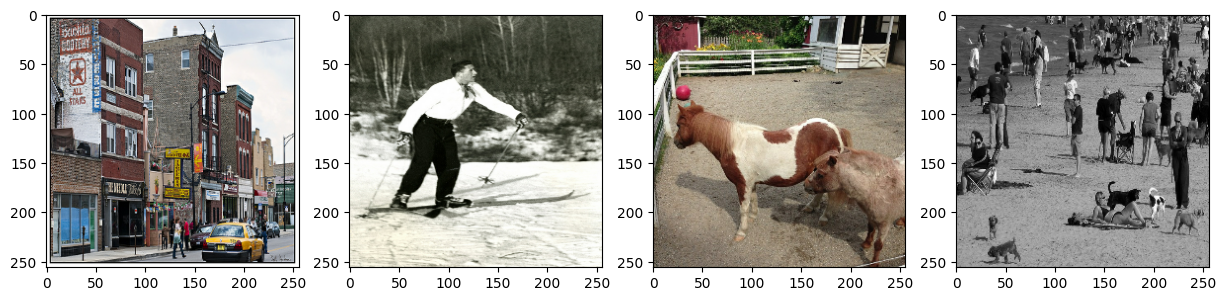

In [63]:
plot_images_grid(next(iter(loader.dataset.take(1))))

In [64]:
# setting up style image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
style_image = load_url_image(url, dim=(input_shape[0], input_shape[1]), resize=True)
style_image = style_image / 255.0

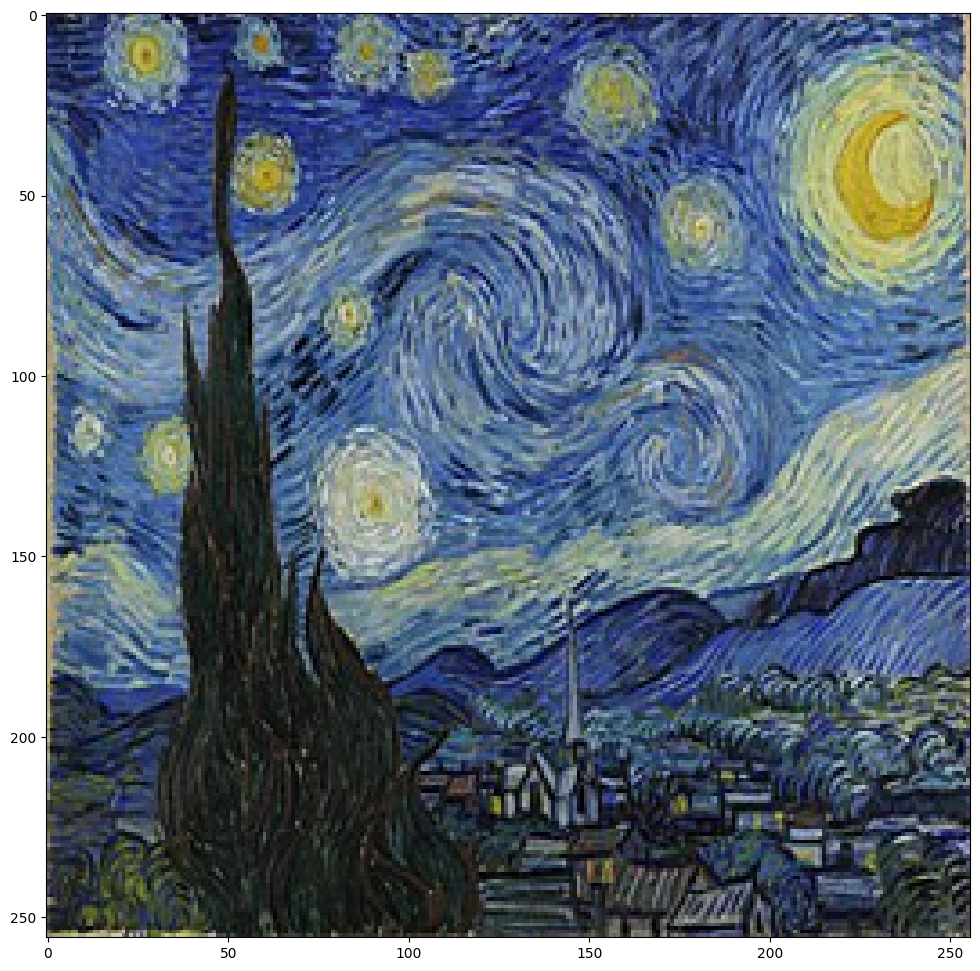

In [65]:
show_image(style_image)

In [35]:
style_image = style_image.astype(np.float32)
style_image_batch = np.repeat([style_image], batch_size, axis=0)
style_activations = loss_model.get_activations(style_image_batch)["style"]

# Training the Model

In [36]:
epochs = 2
content_weight = 1e1
style_weight = 1e2
total_variation_weight = 0.004

In [37]:
num_images = len(loader)
steps_per_epochs = num_images // batch_size
print(steps_per_epochs)

25


In [38]:
model_save_path = "../gdrive/My Drive"
top_folder_name = "scream"
save_path = os.path.join(model_save_path, top_folder_name)
print(save_path)

../gdrive/My Drive/scream


In [39]:
os.makedirs(os.path.join(model_save_path, top_folder_name), exist_ok=True)

In [40]:
try:
    policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
    tf.keras.mixed_precision.experimental.set_policy(policy)
except:
    pass

In [41]:
try:
    tf.config.optimizer.set_jit(True)
except:
    pass

In [42]:
if os.path.isfile(os.path.join(save_path, "model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path, "model_checkpoint.ckpt"))
    print("resuming training ...")
else:
    print("training scratch ...")

training scratch ...


In [43]:
epoch_losses = []
for epoch in range(1, epochs + 1):
    print(f"epoch: {epoch}")
    batch_loss = train_step(
        loader.dataset,
        style_activations,
        steps_per_epochs,
        style_model,
        loss_model,
        optimizer,
        save_path,
        content_weight,
        style_weight,
        total_variation_weight,
        content_layers_weights,
        style_layers_weights,
    )
    style_model.save_weights(os.path.join(save_path, "model_checkpoint.ckpt"))
    print("Model Checkpointed at: ", os.path.join(save_path, "model_checkpoint.ckpt"))
    print(f"loss: {batch_loss.numpy()}")
    epoch_losses.append(batch_loss)

epoch: 1
Model Checkpoint Path:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
Model Checkpointed at:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
loss: 161644672.0
epoch: 2
Model Checkpoint Path:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
Model Checkpointed at:  ../gdrive/My Drive/scream/model_checkpoint.ckpt
loss: 61109864.0


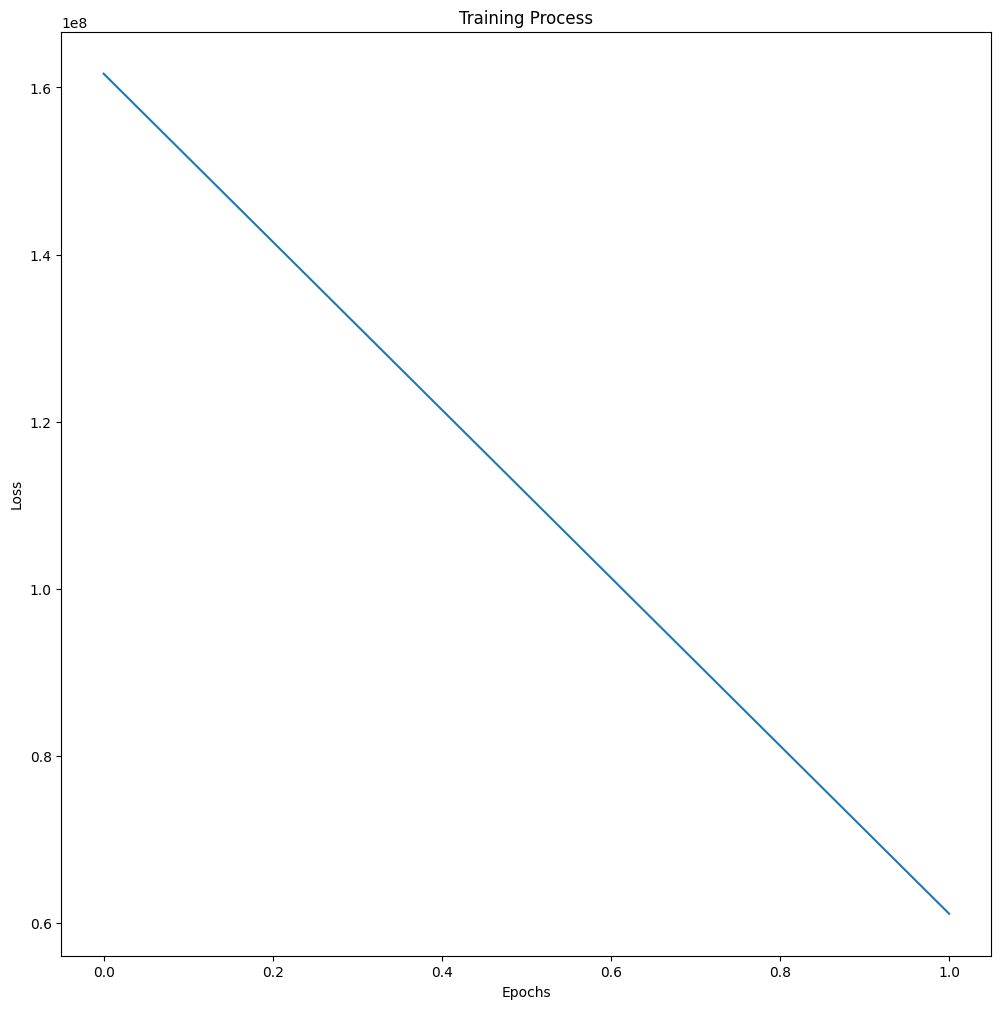

In [44]:
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Process")
plt.show()

In [45]:
if os.path.isfile(os.path.join(save_path, "model_checkpoint.ckpt.index")):
    style_model.load_weights(os.path.join(save_path, "model_checkpoint.ckpt"))
    print("loading weights ...")
else:
    print("no weights found ...")

loading weights ...


In [46]:
test_image_url = "https://github.com/hwalsuklee/tensorflow-fast-style-transfer/raw/master/content/chicago.jpg"

In [48]:
test_image = load_url_image(test_image_url, dim=(640, 480))
test_image = np.expand_dims(test_image, axis=0)

In [49]:
test_image = test_image.astype(np.float32)

In [50]:
predicted_image = style_model(test_image)

In [51]:
predicted_image = np.clip(predicted_image, 0, 255)
predicted_image = predicted_image.astype(np.uint8)

In [52]:
test_output = test_image.astype(np.uint8)
test_output = tf.squeeze(test_output).numpy()
predicted_output = tf.squeeze(predicted_image).numpy()

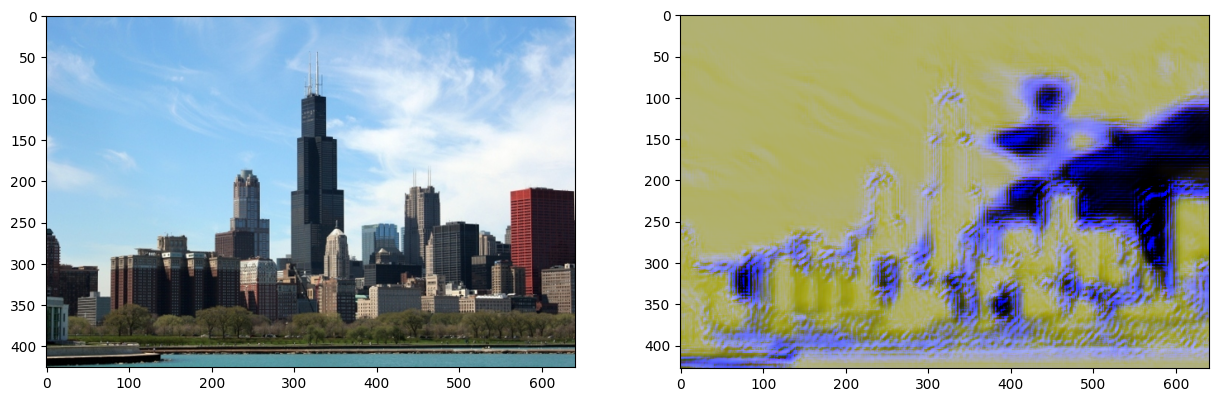

In [53]:
plot_images_grid([test_output, predicted_output])